##### Importing necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

##### Loading and exploring the dataset

In [2]:
# Loading the dataset

data = pd.read_csv('/content/drive/MyDrive/Resume Wallmart Project/Walmart DataSet.csv')

In [3]:
# Displaying some basic information

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  

In [4]:
# Checking for missing values

print(data.isnull().sum())

# Summary statistics

print(data.describe())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000

In [5]:
# Convert 'Date' to datetime format for time-based analysis

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

##### Outlier Analysis and handling

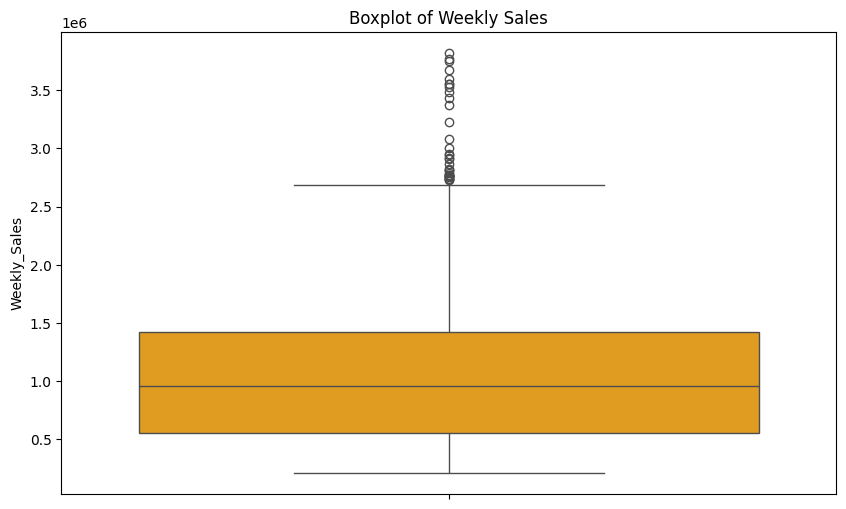

In [6]:
# Boxplot for Weekly Sales

plt.figure(figsize=(10, 6))
sns.boxplot(data['Weekly_Sales'], color='orange')
plt.title("Boxplot of Weekly Sales")
plt.show()

In [7]:
# Identifying the outliers

# Calculate IQR (Interquartile Range)
Q1 = data['Weekly_Sales'].quantile(0.25)
Q3 = data['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count of outliers
outliers = data[(data['Weekly_Sales'] < lower_bound) | (data['Weekly_Sales'] > upper_bound)]
print(f"Number of outliers in Weekly Sales: {len(outliers)}")


Number of outliers in Weekly Sales: 34


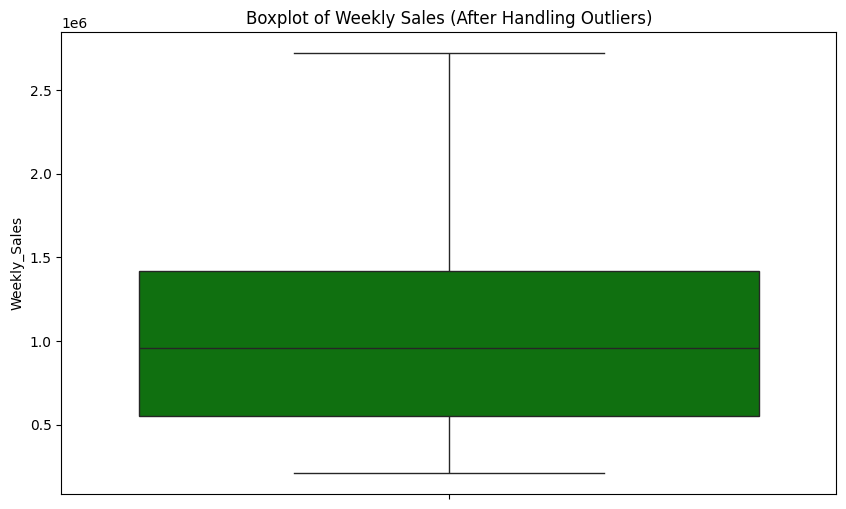

In [8]:
# Handling the outliers

# Cap outliers to upper and lower bounds
data['Weekly_Sales'] = np.where(
    data['Weekly_Sales'] < lower_bound, lower_bound,
    np.where(data['Weekly_Sales'] > upper_bound, upper_bound, data['Weekly_Sales'])
)

# Verify the boxplot after handling
plt.figure(figsize=(10, 6))
sns.boxplot(data['Weekly_Sales'], color='green')
plt.title("Boxplot of Weekly Sales (After Handling Outliers)")
plt.show()


##### Feature Engineering

In [9]:
# Extract additional date features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

# Ensure numerical columns are scaled (useful for modeling)
scaler = StandardScaler()
data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']] = scaler.fit_transform(data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])

# Check the processed dataset
print(data.head())


   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0    -0.995136   -1.713800   
1      1 2010-02-12    1641957.44             1    -1.201170   -1.766089   
2      1 2010-02-19    1611968.17             0    -1.124178   -1.840166   
3      1 2010-02-26    1409727.59             0    -0.760907   -1.737766   
4      1 2010-03-05    1554806.68             0    -0.767955   -1.598328   

        CPI  Unemployment  Year  Month  Week  
0  1.004175      0.056964  2010      2     5  
1  1.007880      0.056964  2010      2     6  
2  1.009074      0.056964  2010      2     7  
3  1.009849      0.056964  2010      2     8  
4  1.010624      0.056964  2010      3     9  


##### Exploratory Data Analysis


###### a. Are weekly sales affected by the unemployment rate? Which stores are suffering the most?


Findings:

A negative correlation suggests that higher unemployment rates are associated with lower sales.
Specific stores with strong negative correlations are identified and visualized

Overall correlation between Weekly Sales and Unemployment: -0.11
Stores with the strongest negative correlation with Unemployment:
Store
38   -0.785290
44   -0.780076
4    -0.449628
dtype: float64


<ipython-input-10-ce527ae3b8d3>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_corr = data.groupby('Store').apply(lambda df: pearsonr(df['Weekly_Sales'], df['Unemployment'])[0])


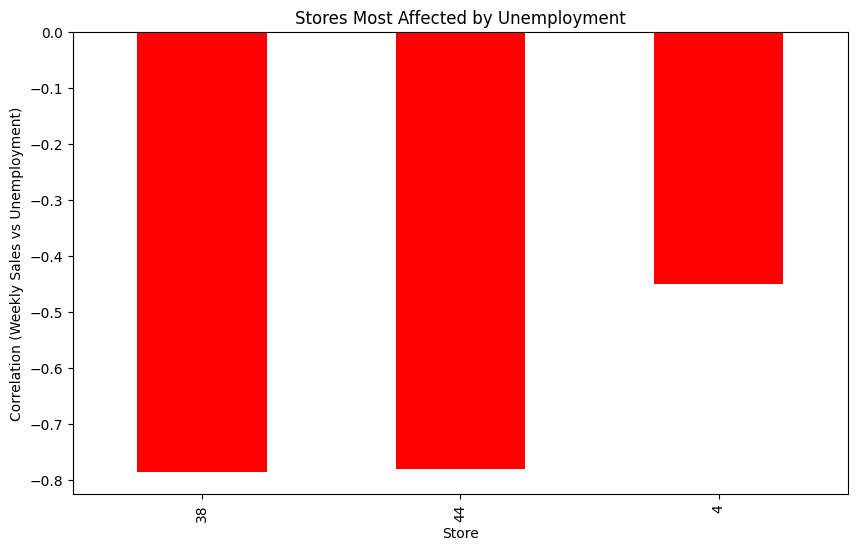

In [10]:
# Correlation between Weekly Sales and Unemployment
overall_corr = pearsonr(data['Weekly_Sales'], data['Unemployment'])[0]
print(f"Overall correlation between Weekly Sales and Unemployment: {overall_corr:.2f}")

# Correlation per store
store_corr = data.groupby('Store').apply(lambda df: pearsonr(df['Weekly_Sales'], df['Unemployment'])[0])
worst_stores = store_corr.nsmallest(3)  # Top 3 stores suffering the most

print("Stores with the strongest negative correlation with Unemployment:")
print(worst_stores)

# Visualization
plt.figure(figsize=(10, 6))
worst_stores.plot(kind='bar', color='red')
plt.title("Stores Most Affected by Unemployment")
plt.xlabel("Store")
plt.ylabel("Correlation (Weekly Sales vs Unemployment)")
plt.show()


##### b. Do weekly sales show a seasonal trend? When and why?


Findings:

Sales typically peak in November and December (holiday season).
Lower sales in January and February may be due to post-holiday spending lulls.

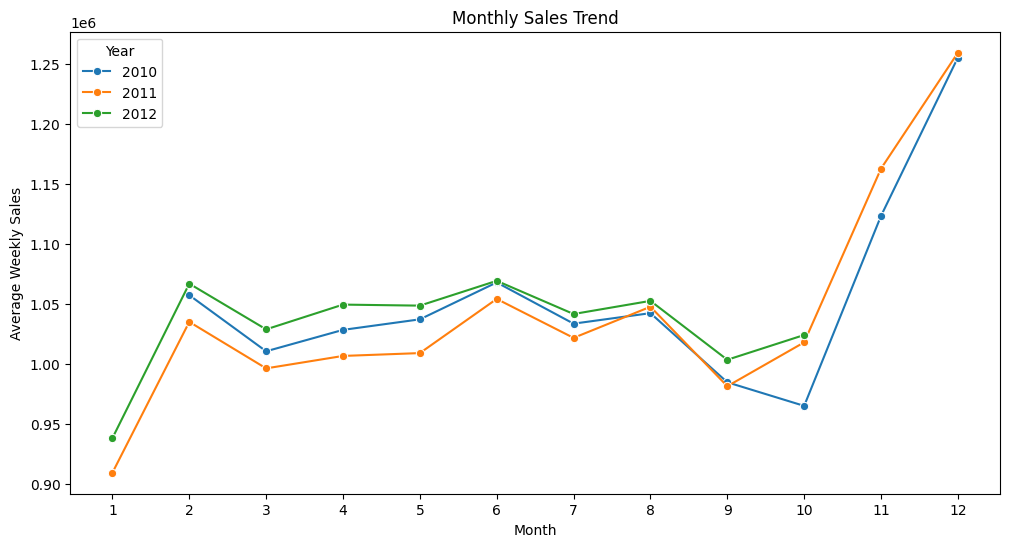

In [11]:
# Monthly trend analysis
monthly_sales = data.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Weekly_Sales', hue='Year', data=monthly_sales, marker='o', palette='tab10')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Average Weekly Sales")
plt.xticks(range(1, 13))
plt.show()


c. Does temperature affect weekly sales in any manner?

Findings:

A weak correlation between temperature and sales. Sales might be more influenced by seasonal and holiday effects.

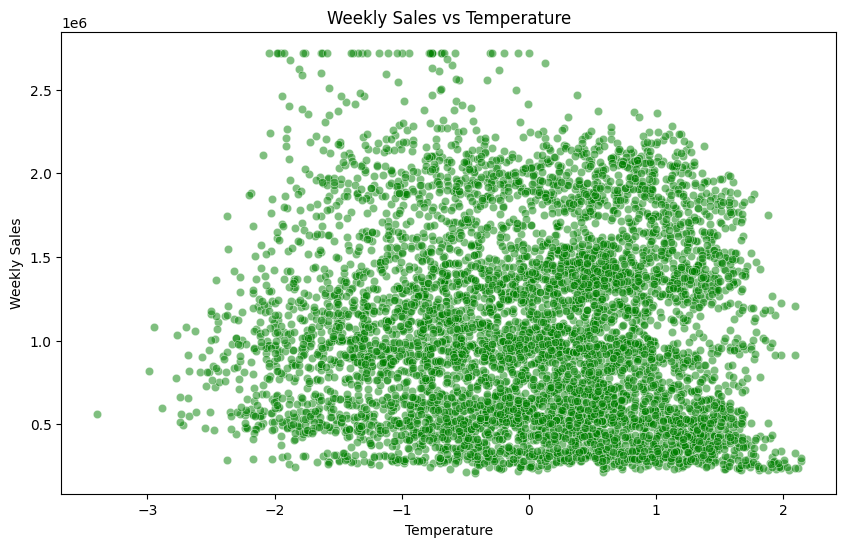

Correlation between Weekly Sales and Temperature: -0.06


In [12]:
# Scatter Plot: Weekly Sales vs Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data, alpha=0.5, color='green')
plt.title("Weekly Sales vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.show()

# Correlation
temp_corr = pearsonr(data['Weekly_Sales'], data['Temperature'])[0]
print(f"Correlation between Weekly Sales and Temperature: {temp_corr:.2f}")


d. How is the Consumer Price Index (CPI) affecting weekly sales across stores?

Findings:

Some stores show a positive correlation (higher CPI means higher sales), while others show a negative correlation.

Top stores positively affected by CPI:
Store
38    0.812837
44    0.740150
4     0.467196
dtype: float64

Top stores negatively affected by CPI:
Store
36   -0.915095
14   -0.482162
35   -0.424107
dtype: float64


<ipython-input-13-eb3fbf3dead8>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_cpi_corr = data.groupby('Store').apply(lambda df: pearsonr(df['Weekly_Sales'], df['CPI'])[0])


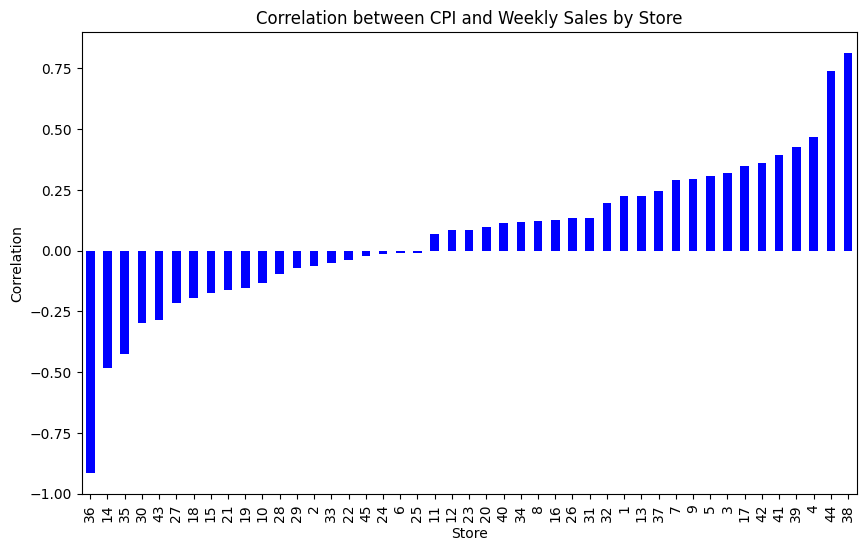

In [13]:
# Correlation per store for CPI
store_cpi_corr = data.groupby('Store').apply(lambda df: pearsonr(df['Weekly_Sales'], df['CPI'])[0])

# Top 3 stores positively and negatively affected
top_cpi_positive = store_cpi_corr.nlargest(3)
top_cpi_negative = store_cpi_corr.nsmallest(3)

print("Top stores positively affected by CPI:")
print(top_cpi_positive)
print("\nTop stores negatively affected by CPI:")
print(top_cpi_negative)

# Visualization
plt.figure(figsize=(10, 6))
store_cpi_corr.sort_values().plot(kind='bar', color='blue')
plt.title("Correlation between CPI and Weekly Sales by Store")
plt.xlabel("Store")
plt.ylabel("Correlation")
plt.show()


e. Top-performing stores based on historical data

Findings:

The top 5 stores contribute significantly to the overall sales.


Top 5 Performing Stores:
 Store
20    2.990663e+08
4     2.973575e+08
14    2.870091e+08
13    2.845247e+08
2     2.741628e+08
Name: Weekly_Sales, dtype: float64


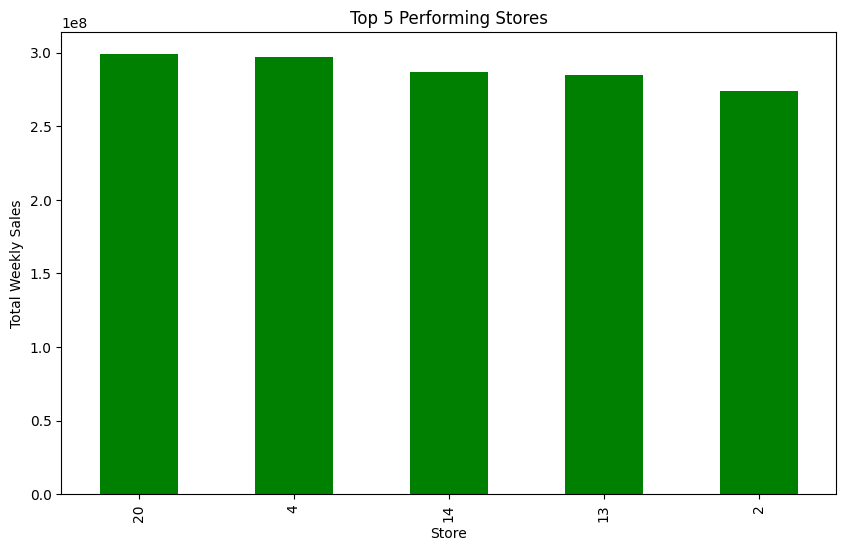

In [14]:
# Total sales by store
store_sales = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

# Top 5 performing stores
top_stores = store_sales.head(5)
print("Top 5 Performing Stores:\n", top_stores)

# Bar Plot
plt.figure(figsize=(10, 6))
top_stores.plot(kind='bar', color='green')
plt.title("Top 5 Performing Stores")
plt.xlabel("Store")
plt.ylabel("Total Weekly Sales")
plt.show()


f. Worst-performing store and significance of difference

Findings:

The difference between the best and worst-performing stores is substantial, indicating room for improvement in lower-performing stores.

Worst Performing Store:
 Store
33    37160221.96
Name: Weekly_Sales, dtype: float64
Difference between best and worst performing stores: 261906113.29749998


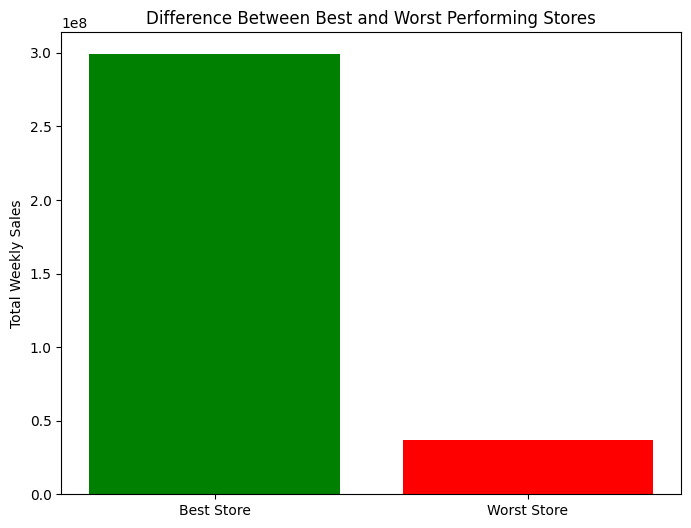

In [15]:
# Worst-performing store
worst_store = store_sales.tail(1)
best_store = store_sales.head(1)

# Calculate difference
diff = best_store.values[0] - worst_store.values[0]

print("Worst Performing Store:\n", worst_store)
print("Difference between best and worst performing stores:", diff)

# Visualize Best vs Worst
plt.figure(figsize=(8, 6))
plt.bar(['Best Store', 'Worst Store'], [best_store.values[0], worst_store.values[0]], color=['green', 'red'])
plt.title("Difference Between Best and Worst Performing Stores")
plt.ylabel("Total Weekly Sales")
plt.show()


##### Predictive modelling

In [16]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.sort_values(by=['Store', 'Date'])

# Group by store and aggregate weekly sales
stores_sales = {store: group[['Date', 'Weekly_Sales']].set_index('Date') for store, group in data.groupby('Store')}


In [22]:
# Select data for Store 1
store_1 = data[data['Store'] == 1].set_index('Date')['Weekly_Sales']

# Train-test split
train = store_1[:-12]  # All but the last 12 weeks
test = store_1[-12:]   # Last 12 weeks for validation

In [24]:
print(type(train))  # Should print <class 'pandas.Series'>
print(train.head())  # Inspect the first few rows


<class 'pandas.core.series.Series'>
Date
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68
Name: Weekly_Sales, dtype: float64


In [26]:
# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # You can tune the order (p, d, q)
arima_model = model.fit()

# Forecast for the next 12 weeks
forecast = arima_model.forecast(steps=12)

# RMSE for the forecast
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse}")


RMSE: 72125.11462224211


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
